In [ ]:
import pandas as pd
import sys, os, ast
import plotly
import plotly.express as px
import plotly.graph_objects as go
from itertools import combinations
from upsetplot import from_memberships, UpSet
import matplotlib.pyplot as plt
import ast
import numpy as np

# Add the parent directory of this notebook to the Python path
sys.path.append(os.path.abspath('..'))

import score

## Example Code for Generating Clinical Prioritization Scores
Demo notebook demonstrating how to take a set of literature indicators to generate new prioritization scores for downstream curation or hypothesis generation efforts.

### Load Indicator Scores

In [2]:
search_strategies = ['raw','ncbi','pubtator3']
assessments = pd.DataFrame()
for strategy in search_strategies:
    tdf = score.load_pmid_assessments(f'search_strategy_evaluation/{strategy}/2025-08-14_BCL2.zip', strategy)
    assessments = pd.concat([assessments,tdf])

tdf = score.load_pmid_assessments('search_strategy_evaluation/pubtator3+drug/2025-08-13_BCL2.zip','pubtator3+drug')

assessments = pd.concat([assessments, tdf])

In [3]:
assessments[assessments['method']=='pubtator3'].groupby(by='pmid').head()

,pmid,label,scores,gene,drug,method
0,39796006,not_evaluated,0.0,BCL2,4-PHENYLBUTYRIC ACID,pubtator3
1,40524014,not_evaluated,0.0,BCL2,4-PHENYLBUTYRIC ACID,pubtator3
2,40393040,not_evaluated,0.0,BCL2,4-PHENYLBUTYRIC ACID,pubtator3
3,40619042,not_evaluated,0.0,BCL2,4-PHENYLBUTYRIC ACID,pubtator3
4,40444042,not_evaluated,0.0,BCL2,4-PHENYLBUTYRIC ACID,pubtator3
...,...,...,...,...,...,...
49995,34898246,not_evaluated,0.0,BCL2,ANG1005,pubtator3
49996,34434246,not_evaluated,0.0,BCL2,ANG1005,pubtator3
49997,30644246,not_evaluated,0.0,BCL2,ANG1005,pubtator3
49998,37748246,not_evaluated,0.0,BCL2,ANG1005,pubtator3


In [4]:
assessments[(assessments['scores']!='0.0') & (assessments['scores']!=0.0) & (assessments['label']!='no_indicator_evidence')]['method'].value_counts()

method
pubtator3+drug    1073
raw                382
pubtator3          270
ncbi                45
Name: count, dtype: int64

### Attach Indicators to DGIdb Search Set
Now that we have indicators loaded from our NLP methods, let's calculate and attach them to their relevant search terms

In [5]:
dgidb_df = pd.read_csv('search/2025-08-14_BCL2_clin_score.csv')
dgidb_df = dgidb_df.drop_duplicates(subset=['Drug','Gene'], keep='first')
dgidb_df.head()

,nomenclature,Gene,long_name,gene_concept_id,interaction_score,drug_specificity,gene_specificity,evidence_score,source_db_name,source_db_version,...,directionality,definition,reference,drug_name,nomenclature-2,Drug,approved,immunotherapy,anti_neoplastic,drug_concept_id
0,Gene Symbol,BCL2,BCL2 apoptosis regulator,hgnc:990,2.284732,4.141413,0.183893,3.0,TALC,12-May-16,...,1.0,"In inhibitor interactions, the drug binds to a...","<a href=""https://en.wikipedia.org/wiki/Enzyme_...",OBLIMERSEN,Primary Name,OBLIMERSEN,False,False,True,ncit:C1870
3,Gene Name,BCL2,BCL2 apoptosis regulator,hgnc:990,1.523154,4.141413,0.183893,2.0,NCI,14-Sep-17,...,NaN,NaN,NaN,DOLASTATIN 10,Primary Name,DOLASTATIN 10,False,False,False,ncit:C1300
4,Gene Name,BCL2,BCL2 apoptosis regulator,hgnc:990,1.523154,4.141413,0.183893,2.0,NCI,14-Sep-17,...,NaN,NaN,NaN,EPISIALIN,Primary Name,MUC-1 ANTIGEN,False,False,False,ncit:C2407
5,Gene Name,BCL2,BCL2 apoptosis regulator,hgnc:990,1.523154,4.141413,0.183893,2.0,NCI,14-Sep-17,...,NaN,NaN,NaN,MICELLAR PACLITAXEL,Primary Name,MICELLAR PACLITAXEL,False,False,False,ncit:C29256
6,Gene Name,BCL2,BCL2 apoptosis regulator,hgnc:990,1.523154,4.141413,0.183893,2.0,NCI,14-Sep-17,...,NaN,NaN,NaN,BEAUVERICIN,Primary Name,BEAUVERICIN,False,False,False,ncit:C1011


In [41]:
def unpack_total(score):
    if type(score) is float:
        return 0
    if score is None:
        return 0
    return ast.literal_eval(score)['unweighted_total']

trimmed_data = assessments[(assessments['scores']!='0.0') & (assessments['scores']!=0.0) & (assessments['label']!='no_indicator_evidence') & (assessments['scores'].isna()==False)].reset_index(drop=True)

trimmed_data['pmid_indicator'] = trimmed_data['scores'].apply(unpack_total)

drugs = list(trimmed_data['drug'].unique())

trimmed_data['total_indicator'] = trimmed_data.groupby(['drug','method'])['pmid_indicator'].transform("sum")

trimmed_data


,pmid,label,scores,gene,drug,method,is_relevant,pmid_indicator,total_indicator
0,37753296,indicator_evidence,"{'clinical_study': 0, 'case_report': 0, 'anima...",BCL2,4-PHENYLBUTYRIC ACID,raw,True,2,2
1,40253027,indicator_evidence,"{'clinical_study': 1, 'case_report': 0, 'anima...",BCL2,AMINOLEVULINIC ACID,raw,True,5,5
2,40612794,indicator_evidence,"{'clinical_study': 0, 'case_report': 0, 'anima...",BCL2,BEAUVERICIN,raw,True,2,2
3,40593443,indicator_evidence,"{'clinical_study': 1, 'case_report': 0, 'anima...",BCL2,BORTEZOMIB,raw,True,4,27
4,40539846,indicator_evidence,"{'clinical_study': 1, 'case_report': 0, 'anima...",BCL2,BORTEZOMIB,raw,True,2,27
...,...,...,...,...,...,...,...,...,...
1765,24289107,indicator_evidence,"{'clinical_study': 1, 'case_report': 0, 'anima...",BCL2,VINCRISTINE,pubtator3+drug,True,2,349
1766,26301373,indicator_evidence,"{'clinical_study': 0, 'case_report': 0, 'anima...",BCL2,VINCRISTINE,pubtator3+drug,True,4,349
1767,25090026,indicator_evidence,"{'clinical_study': 1, 'case_report': 0, 'anima...",BCL2,VINCRISTINE,pubtator3+drug,True,1,349
1768,27628560,indicator_evidence,"{'clinical_study': 0, 'case_report': 0, 'anima...",BCL2,VINCRISTINE,pubtator3+drug,True,2,349


In [7]:
summary = (trimmed_data.groupby(["gene", "drug", "method"], as_index=False).agg(total_indicator=("total_indicator", "first")))

method = 'pubtator3'
summary = summary[summary['method']==method].reset_index(drop=True)

merged_df = pd.merge(
    summary,
    dgidb_df,
    left_on='drug',
    right_on='Drug',
    how='left'
)
merged_df.head()

,gene,drug,method,total_indicator,nomenclature,Gene,long_name,gene_concept_id,interaction_score,drug_specificity,...,directionality,definition,reference,drug_name,nomenclature-2,Drug,approved,immunotherapy,anti_neoplastic,drug_concept_id
0,BCL2,ALPHA-TOCOPHEROL,pubtator3,2,Gene Name,BCL2,BCL2 apoptosis regulator,hgnc:990,0.138469,0.376492,...,NaN,NaN,NaN,ALPHA-TOCOPHEROL,Primary Name,ALPHA-TOCOPHEROL,False,False,False,ncit:C74960
1,BCL2,AMINOLEVULINIC ACID,pubtator3,11,Gene Name,BCL2,BCL2 apoptosis regulator,hgnc:990,1.523154,4.141413,...,NaN,NaN,NaN,5-AMINOLAEVULINIC ACID,Primary Name,AMINOLEVULINIC ACID,False,False,False,ncit:C234
2,BCL2,BORTEZOMIB,pubtator3,12,Gene Name,BCL2,BCL2 apoptosis regulator,hgnc:990,0.009066,0.049303,...,NaN,NaN,NaN,Bortezomib,Primary Name,BORTEZOMIB,True,False,True,rxcui:358258
3,BCL2,C5A,pubtator3,4,Gene Name,BCL2,BCL2 apoptosis regulator,hgnc:990,0.217593,0.591630,...,NaN,NaN,NaN,C5A,Primary Name,C5A,False,False,False,iuphar.ligand:3576
4,BCL2,CARBOPLATIN,pubtator3,7,Gene Symbol,BCL2,BCL2 apoptosis regulator,hgnc:990,0.008960,0.048723,...,NaN,NaN,NaN,CARBOPLATIN,Primary Name,CARBOPLATIN,True,False,True,rxcui:40048


### Create Graphs for Research

In [8]:
trimmed_data.head()

,pmid,label,scores,gene,drug,method,pmid_indicator,total_indicator
0,37753296,indicator_evidence,"{'clinical_study': 0, 'case_report': 0, 'anima...",BCL2,4-PHENYLBUTYRIC ACID,raw,2,2
1,40253027,indicator_evidence,"{'clinical_study': 1, 'case_report': 0, 'anima...",BCL2,AMINOLEVULINIC ACID,raw,5,5
2,40612794,indicator_evidence,"{'clinical_study': 0, 'case_report': 0, 'anima...",BCL2,BEAUVERICIN,raw,2,2
3,40593443,indicator_evidence,"{'clinical_study': 1, 'case_report': 0, 'anima...",BCL2,BORTEZOMIB,raw,4,27
4,40539846,indicator_evidence,"{'clinical_study': 1, 'case_report': 0, 'anima...",BCL2,BORTEZOMIB,raw,2,27


#### Relevance
Proportion of abstracts retrieved that are relevant to scoring objective. If an abstract is pulled and has no indicator_evidence, then it is not relevant.

In [23]:
def generate_relevance_graph(df, method):
    # Subset
    subset = df[df['method']==method]

    # Calculate Overall Relevance Rate
    total_pmids = subset['pmid'].nunique()
    relevant_pmids = subset[subset['is_relevant']]['pmid'].nunique()
    overall_relevance_rate = (relevant_pmids / total_pmids) * 100

    # Relevance Rate by Abstract
    pmid_grouped = subset.groupby('pmid')['is_relevant'].agg(total_mentions='count', relevant_mentions='sum').reset_index()
    pmid_grouped['relevance_rate'] = (pmid_grouped['relevant_mentions'] / pmid_grouped['total_mentions']) * 100
    pmid_grouped['relevance_rate'].value_counts()
    
    # Graph
    gene = str(df['gene'].iloc[0]).replace(" ", "_")
    fig = px.histogram(pmid_grouped, x='relevance_rate',nbins=50, title=f'Abstract Relevance Rate ({method})', labels={'relevance_rate': 'Relevance Rate (PMID)'}, opacity=0.75)
    fig.update_layout(xaxis_title='Relevance Rate (%, 0.0 = no clinical relation, 1.0 = fully relevant)',
                    yaxis_title='Number of Abstracts',
                    bargap=0.1)
    fig.write_image(f'data/results/{gene}_{method}_relevance_rate_histogram.png', width=800, height=600, scale=2)
    
    return overall_relevance_rate, pmid_grouped['relevance_rate'].value_counts()



assessments['is_relevant'] = assessments['label'] == 'indicator_evidence'
for method in ['raw','ncbi','pubtator3','pubtator3+drug']:
    print(method, '\n', generate_relevance_graph(assessments, method))



raw 
 (3.5219995868622185, relevance_rate
0.000000    9341
1.298701     306
2.597403      31
3.896104       2
5.194805       2
Name: count, dtype: int64)
ncbi 
 (1.99700449326011, relevance_rate
0.000000    1963
1.298701      36
2.597403       3
3.896104       1
Name: count, dtype: int64)
pubtator3 
 (2.399357494227487, relevance_rate
0.000000    9722
1.298701     210
2.597403      27
3.896104       2
Name: count, dtype: int64)
pubtator3+drug 
 (7.340309230048415, relevance_rate
0.000000    11866
1.298701      821
2.597403      106
3.896104       12
5.194805        1
Name: count, dtype: int64)


#### Uniqueness of PMIDs
Assess the total PMIDs, unique PMIDs, and general overlap between all search strategies

In [14]:
assessments.head()

,pmid,label,scores,gene,drug,method,is_relevant
0,40810224,not_evaluated,0.0,BCL2,4-PHENYLBUTYRIC ACID,raw,False
1,40809918,not_evaluated,0.0,BCL2,4-PHENYLBUTYRIC ACID,raw,False
2,40809891,not_evaluated,0.0,BCL2,4-PHENYLBUTYRIC ACID,raw,False
3,40809237,not_evaluated,0.0,BCL2,4-PHENYLBUTYRIC ACID,raw,False
4,40809170,not_evaluated,0.0,BCL2,4-PHENYLBUTYRIC ACID,raw,False


/Users/mjc014/.pyenv/versions/3.12.2/lib/python3.12/site-packages/upsetplot/data.py:303: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/Users/mjc014/.pyenv/versions/3.12.2/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/Users/mjc014/.pyenv/versions/3.12.2/l

<Figure size 1200x600 with 0 Axes>

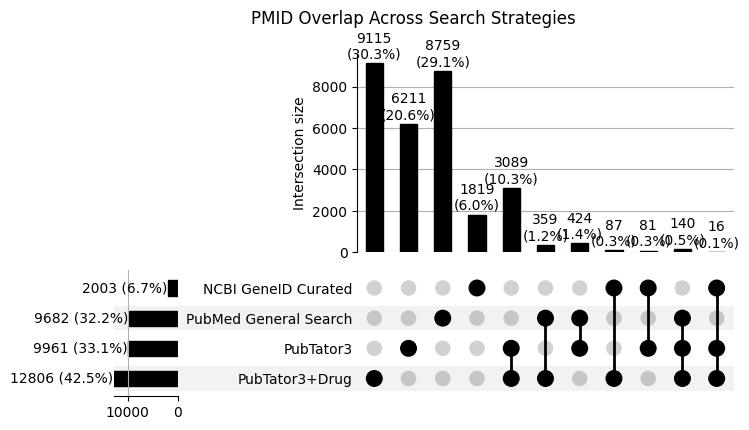

In [19]:
# Identify unique PMIDs for each search strategy
pmids_1 = set(assessments[assessments['method']=='ncbi']['pmid'].unique())
pmids_2 = set(assessments[assessments['method']=='raw']['pmid'].unique())
pmids_3 = set(assessments[assessments['method']=='pubtator3']['pmid'].unique())
pmids_4 = set(assessments[assessments['method']=='pubtator3+drug']['pmid'].unique())

all_pmids = pmids_1 | pmids_2 | pmids_3 | pmids_4
memberships = []

for pmid in all_pmids:
    membership = []
    if pmid in pmids_1:
        membership.append("NCBI GeneID Curated")
    if pmid in pmids_2:
        membership.append("PubMed General Search")
    if pmid in pmids_3:
        membership.append("PubTator3")
    if pmid in pmids_4:
        membership.append("PubTator3+Drug")
    memberships.append(membership)


data = from_memberships(memberships)
upset = UpSet(data, subset_size='count', show_counts=True, show_percentages=True)
plt.figure(figsize=(12, 6))
upset.plot()
plt.suptitle("PMID Overlap Across Search Strategies")
plt.tight_layout()

gene = str(assessments['gene'].iloc[0]).replace(" ", "_")
plt.savefig(f'data/results/{gene}-pmid_overlap_upsetplot.png', dpi=300)

plt.show()



In [21]:
strategies = {
    "NCBI GeneID Curated": pmids_1,
    "PubMed General Search": pmids_2,
    "PubTator3": pmids_3,
    "PubTator3+Drug": pmids_4
}

print("\nPairwise Jaccard Similarities:\n")
for (name1, set1), (name2, set2) in combinations(strategies.items(), 2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    jaccard = intersection / union
    print(f"{name1} ∩ {name2}: {jaccard:.2%} ({intersection} shared PMIDs)")

strategy_names = list(strategies.keys())
jaccard_matrix = pd.DataFrame(index=strategy_names, columns=strategy_names, dtype=float)

for name1 in strategy_names:
    for name2 in strategy_names:
        set1 = strategies[name1]
        set2 = strategies[name2]
        if name1 == name2:
            jaccard = 1.0
        else:
            intersection = len(set1 & set2)
            union = len(set1 | set2)
            jaccard = intersection / union if union else 0.0
        jaccard_matrix.loc[name1, name2] = jaccard

fig = px.imshow(
    jaccard_matrix,
    text_auto=".2f",
    color_continuous_scale='Blues',
    labels=dict(x="Strategy", y="Strategy", color="Jaccard Index"),
    title="Pairwise Jaccard Similarity Between Search Strategies"
)
fig.update_layout(width=600, height=600)
fig.show()
gene = str(assessments['gene'].iloc[0]).replace(" ", "_")
fig.write_image(f'data/results/{gene}-jaccard_similarity_heatmap.png', width=800, height=600, scale=2)


Pairwise Jaccard Similarities:

NCBI GeneID Curated ∩ PubMed General Search: 0.00% (0 shared PMIDs)
NCBI GeneID Curated ∩ PubTator3: 0.82% (97 shared PMIDs)
NCBI GeneID Curated ∩ PubTator3+Drug: 0.70% (103 shared PMIDs)
PubMed General Search ∩ PubTator3: 2.96% (564 shared PMIDs)
PubMed General Search ∩ PubTator3+Drug: 2.27% (499 shared PMIDs)
PubTator3 ∩ PubTator3+Drug: 16.62% (3245 shared PMIDs)


#### Score Density

In [35]:
assessments

,pmid,label,scores,gene,drug,method,is_relevant
0,40810224,not_evaluated,0.0,BCL2,4-PHENYLBUTYRIC ACID,raw,False
1,40809918,not_evaluated,0.0,BCL2,4-PHENYLBUTYRIC ACID,raw,False
2,40809891,not_evaluated,0.0,BCL2,4-PHENYLBUTYRIC ACID,raw,False
3,40809237,not_evaluated,0.0,BCL2,4-PHENYLBUTYRIC ACID,raw,False
4,40809170,not_evaluated,0.0,BCL2,4-PHENYLBUTYRIC ACID,raw,False
...,...,...,...,...,...,...,...
986057,31799611,not_evaluated,0.0,BCL2,VINCRISTINE,pubtator3+drug,False
986058,34567953,not_evaluated,0.0,BCL2,VINCRISTINE,pubtator3+drug,False
986059,34631583,not_evaluated,0.0,BCL2,VINCRISTINE,pubtator3+drug,False
986060,33760220,not_evaluated,0.0,BCL2,VINCRISTINE,pubtator3+drug,False


In [49]:
def unpack_total_safe(score):
    # Handle None / NaN
    if score is None or (isinstance(score, float) and np.isnan(score)):
        return 0.0
    
    # If it's already a number (int or float), just return it
    if isinstance(score, (int, float)):
        return float(score)

    # If it's a dict-like object
    if isinstance(score, dict):
        return float(score.get('unweighted_total', 0.0))

    # If it's a string that might contain a dict
    if isinstance(score, str):
        try:
            val = ast.literal_eval(score)
            if isinstance(val, dict):
                return float(val.get('unweighted_total', 0.0))
            elif isinstance(val, (int, float)):
                return float(val)
        except Exception:
            return 0.0

    # Fallback
    return 0.0


def compute_score_density(df, strategy_name):
    # All abstracts
    df = df[df['scores'].isna()==False]
    df['total_indicators'] = df['scores'].apply(unpack_total_safe)
    all_grouped = df.groupby('pmid')['total_indicators'].sum()
    all_scd = all_grouped.mean()
    
    # Only clinically relevant abstracts
    clinical_df = df[df['label'] == 'indicator_evidence']
    if not clinical_df.empty:
        clinical_grouped = clinical_df.groupby('pmid')['total_indicators'].sum()
        clinical_scd = clinical_grouped.mean()
    else:
        clinical_scd = 0.0  # or np.nan

    return {
        'Strategy': strategy_name,
        'Total Abstracts': df['pmid'].nunique(),
        'Clinically Relevant Abstracts': clinical_df['pmid'].nunique(),
        'Score Density (All Abstracts)': all_scd,
        'Score Density (Clinical Only)': clinical_scd
    }

In [ ]:
# BCL2 Results
_ncbi = assessments[assessments['method']=='ncbi']
_raw = assessments[assessments['method']=='raw']
_pubtator3 = assessments[assessments['method']=='pubtator3']
_pubtator3drug = assessments[assessments['method']=='pubtator3+drug']

# Compute all densities
results = []
results.append(compute_score_density(_ncbi,'NCBI GeneID Curated'))
results.append(compute_score_density(_raw,'PubMed General Search'))
results.append(compute_score_density(_pubtator3,'PubTator3'))
results.append(compute_score_density(_pubtator3drug,'PubTator3+Drug'))

results

[{'Strategy': 'NCBI GeneID Curated',
  'Total Abstracts': 2003,
  'Clinically Relevant Abstracts': 40,
  'Score Density (All Abstracts)': 0.05591612581128307,
  'Score Density (Clinical Only)': 2.8},
 {'Strategy': 'PubMed General Search',
  'Total Abstracts': 9682,
  'Clinically Relevant Abstracts': 341,
  'Score Density (All Abstracts)': 0.10989464986573022,
  'Score Density (Clinical Only)': 3.1202346041055717},
 {'Strategy': 'PubTator3',
  'Total Abstracts': 9961,
  'Clinically Relevant Abstracts': 239,
  'Score Density (All Abstracts)': 0.07308503162333099,
  'Score Density (Clinical Only)': 3.0460251046025104},
 {'Strategy': 'PubTator3+Drug',
  'Total Abstracts': 12806,
  'Clinically Relevant Abstracts': 940,
  'Score Density (All Abstracts)': 0.22333281274402625,
  'Score Density (Clinical Only)': 3.0425531914893615}]

In [50]:
scd_df = pd.DataFrame(results)
fig = px.bar(
    scd_df.melt(id_vars='Strategy', value_vars=[
        'Score Density (All Abstracts)',
        'Score Density (Clinical Only)'
    ]),
    x='Strategy',
    y='value',
    color='variable',
    barmode='group',
    title='Score Contribution Density by Search Strategy',
    labels={'value': 'Average Indicator per Abstract'}
)
fig.show()

gene = str(assessments['gene'].iloc[0]).replace(" ", "_")
fig.write_image(f'data/results/{gene}-score_contribution_density.png', width=800, height=600, scale=2)

#### Top 10 Interactions by Strategy


In [51]:
def adjust_one(value):
    return value + 1

In [ ]:
# TODO: Create results tables by search strategy, graph, also mask CHEMOTHERAPY_AGENTS


# Calculate Clinical Score
for idx, row in merged_df.iterrows():
    try:
        merged_df.at[idx,'clinical_score'] = float(row['total_indicator']) * float(row['drug_specificity']) * float(row['gene_specificity'])
    except:
        merged_df.at[idx,'clinical_score'] = None

merged_df #total_indicator

# Rankings
tdf = merged_df.sort_values(by='interaction_score',ascending=False).reset_index(drop=True)
tdf = tdf.drop_duplicates(subset=['Gene', 'Drug']).reset_index(drop=True)
tdf['IS_Ranking'] = tdf.index
tdf['IS_Ranking'] = tdf['IS_Ranking'].apply(adjust_one)

tdf = tdf.sort_values(by='clinical_score',ascending=False).reset_index(drop=True)
tdf['CS_Ranking'] = tdf.index
tdf['CS_Ranking'] = tdf['CS_Ranking'].apply(adjust_one)

top10_1 = set(tdf.sort_values('CS_Ranking').head(10)['Drug'])

tdf[['Drug','interaction_score','total_indicator','clinical_score','IS_Ranking','CS_Ranking']][0:10]


,Drug,interaction_score,total_indicator,clinical_score,IS_Ranking,CS_Ranking
0,VENETOCLAX,0.169239,301,12.735264,9,1
1,AMINOLEVULINIC ACID,1.523154,11,8.37735,1,2
2,NAVITOCLAX,0.271992,35,1.903943,5,3
3,TRAIL,0.175749,21,1.23024,8,4
4,VINCRISTINE,0.009520,104,0.99005,29,5
5,LYSOZYME,0.507718,3,0.761577,3,6
6,HYPOXANTHINE,0.507718,3,0.761577,2,7
7,CISPLATIN,0.020865,109,0.568575,26,8
8,SELENIUM,0.134396,11,0.492785,14,9
9,C5A,0.217593,4,0.435187,6,10
